# Linear Image Denoising

This numerical tour introduces basic image denoising methods.

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


In [1]:
from __future__ import division
from nt_toolbox.general import *
from nt_toolbox.signal import *
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/gpeyre/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/gpeyre/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


/Users/gpeyre/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Noisy Image Formation

In these numerical tour, we simulate noisy acquisition by adding some
white noise (each pixel is corrupted by adding an independant Gaussian
variable).


This is useful to test in an oracle maner the performance of our methods.


Size $N = n \times n$ of the image.

In [2]:
n = 256
N = n**2

We load a clean image $x_0 \in \RR^N$.

In [3]:
name = 'nt_toolbox/data/flowers.png'
x0 = load_image(name, n)

Display the clean image.

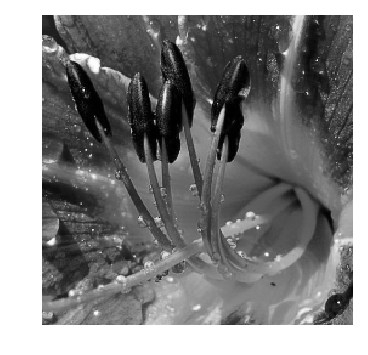

In [4]:
imageplot(x0)

Variance of the noise.

In [5]:
sigma = .08

We add some noise to it to obtain the noisy signal $y = x_0 + w$.
Here $w$ is a realization of a Gaussian white noise of variance
$\si^2$.

In [6]:
y = x0 + sigma*random.standard_normal(x0.shape)

Display the noisy image.

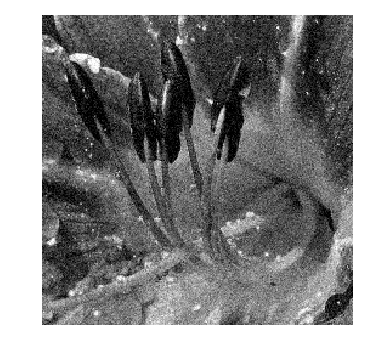

In [7]:
imageplot(clamp(y))

## Linear Image Denoising

We consider a noising estimator $x \in \RR^N$ of $x_0$ that only
depends on the observation $y$. Mathematically speaking, it is thus a
random vector that depends on the noise $w$.


A translation invariant linear denoising is necessarely a convolution
with a kernel $h$
$$ x = x_0 \star h $$
where the periodic convolution between two 2-D arrays is defined as
$$ (a \star b)_i = \sum_j a(j) b(i-j). $$


It can be computed over the Fourier domain as
$$ \forall \om, \quad \hat x(\om) = \hat x_0(\om) \hat h(\om). $$

In [8]:
cconv = lambda a,b : real(ifft2(fft2(a)*fft2(b)))

We use here a Gaussian fitler $h$ parameterized by
the bandwith $\mu$.

In [9]:
normalize = lambda h : h/sum(h.flatten())
t = transpose( concatenate( (arange(0,n/2), arange(-n/2,0) ) ) )
[Y,X] = meshgrid(t, t)
h = lambda mu: normalize(exp(-(X**2 + Y**2)/ (2*mu**2)))

Display the filter $h$ and its Fourier transform.

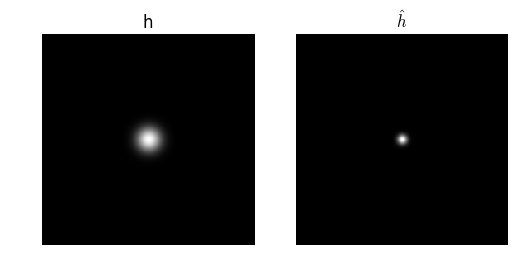

In [10]:
mu = 10
subplot(1,2, 1)
imageplot(fftshift(h(mu)))
title('h')
subplot(1,2, 2)
imageplot(fftshift(real(fft2(h(mu)))))
title('$\hat h$');

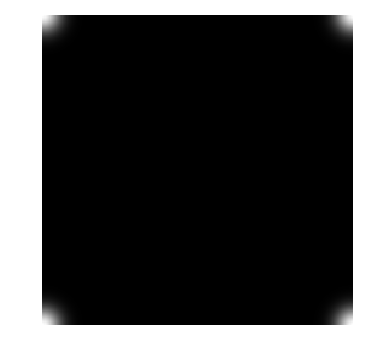

In [11]:
imageplot(h(mu))

Shortcut for the convolution with $h$.

In [12]:
denoise = lambda x,mu : cconv(h(mu), x)

Display a denoised signal.

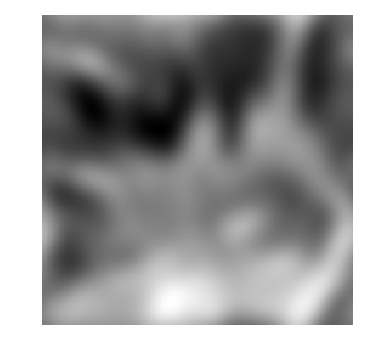

In [13]:
imageplot(denoise(y, mu))

**Exercise 1:** Display a denoised signal for several values of $\mu$.

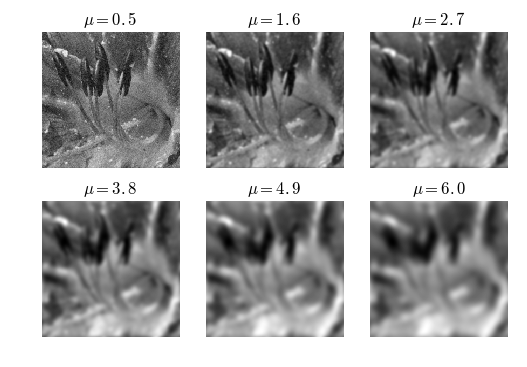

In [14]:
run -i nt_solutions/denoisingsimp_2b_linear_image/exo1

**Exercise 2:** Display the evolution of the oracle denoising error
$ \norm{y-x_0} $ as a function of $\mu$.
Set $\mu$ to the value of the optimal parameter. 

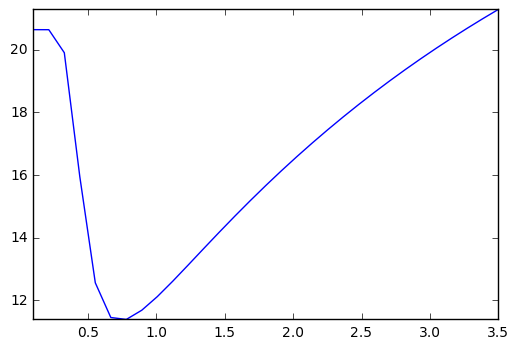

In [15]:
run -i nt_solutions/denoisingsimp_2b_linear_image/exo2

Display the results.

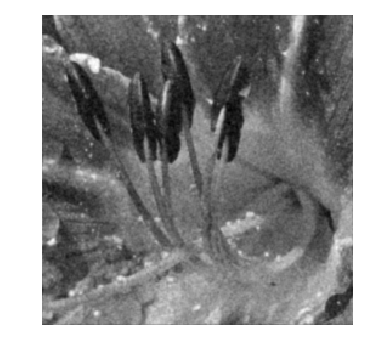

In [16]:
imageplot(denoise(y, mu))

## Wiener Filtering

We suppose here that $x_0$ is a realization of a random vector $x_0$,
whose distribution is Gaussian with a stationary covariance $c$,
and we denote $P_{X_0}(\om) = \hat c(\om)$ the power-spectrum of
$x_0$.


Recall that $w$ is a realization of a random vector $W$
distributed according to $\Nn(0,\si^2 \text{Id})$.


The (oracle) optimal filter minimizes the risk
$$ R(h) = \EE_{W,X_0}( \norm{ X_0 - h \star (X_0 + W) }^2 ). $$


One can show that the solution of this problem, the so-called Wiener filter,
is defined as
$$ \forall \om, \quad \hat h(\om) = \frac{ P_{X_0}(\om) }{ P_{X_0}(\om) + \si^2 }. $$


We estimate $ P_{X_0} $ using the periodogram associated to the
realization $x_0$, i.e.
$$ P_{X_0} \approx \frac{1}{N}\abs{\hat x_0}^2. $$

In [17]:
P = 1/N * ( abs(fft2(x0))**2 )

Compute the approximate Wiener filter.

In [18]:
h_w = real(ifft2(P / (P + sigma**2)))

Note that this is a theoretical filter, because in practice one does not
have access to $x_0$. Display it.

nt_solutions/denoisingsimp_2b_linear_image/exo2.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # err = arrayfun(@(mu)norm(x0-denoise(y,mu), 'fro' ), mulist);


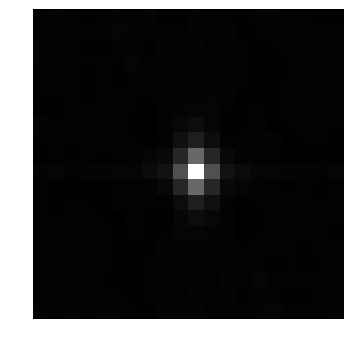

In [19]:
u = fftshift(h_w)
imageplot( u[n/2-10:n/2+10,n/2-10:n/2+10] )

Display the denoising result.

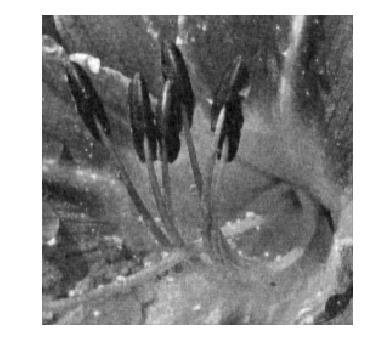

In [20]:
imageplot( cconv(y,h_w) )

Note that this denoising is not very efficient, because the hypothesis of
stationarity of $X_0$ is not realistic for such piecewise-regular
signal.